**Validation Metrics**

This notebook accepts a trained model and outputs statistics of its performance.

* Performance on training, validation, and test set
* Plot our predictions versus assay output
* Overlap with conservation scores
* Overlap with CENTIPEDE motifs
* Scatter plot of our importance scores versus SHARPR scores
* ... Things I missed :)

**General Strategy for Importance Scores**

Let's try to get all types of importance scores into  nested dictionaries of the following spec:

(promoter, cell_type) -> chromosome -> position -> score


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def quantile_plot(data_pairs, quantiles = 5000):
    data_pairs = sorted(data_pairs, key = lambda x: x[0])
    avg_activity, avg_score = [], []
    for i in range(0, len(data_pairs), len(data_pairs) / quantiles):
        index = range(i, min(i + (len(data_pairs) / quantiles), len(data_pairs)))
        activities = [data_pairs[j][0] for j in index]
        scores  = [data_pairs[j][1] for j in index]
        avg_activity.append(sum(activities) / float(len(activities)))
        avg_score.append(sum(scores) / float(len(scores)))
    i = 0
    while avg_activity[i] < 0: i += 1
    rho, pval = spearmanr(avg_activity[i:], avg_score[i:])
    print rho, pval
    plt.scatter(avg_activity, avg_score)
    plt.show()

# Load in Experimental Data and SHARPR Predictions

In [3]:
# This loads in the experimental data
from mrpa_data import MrpaData
data = MrpaData()

mrpa_data.py:116: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCG.
  warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
mrpa_data.py:116: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCGCCGCC.
  warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
mrpa_data.py:116: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNNNNNNNNNNGAATTCAATGGAGTGGACTGGAGTGCTGTGGGGTGGAGTGGAATGGAGTGTAGTTGAATGGAGTGGAATGGAATGCGATGGAATGGAGTGGAGTTGAGCAGAGTGAAGTGGAAAGGTGTAGAATGGA.
  warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
mrpa_data.py:116: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNNNNNGAATTCAATGGAGTGGACTGGAGTGCTGTGGGGTGGAGTGGAA

In [4]:
# Loads in SHARPR activity scores
sharpr = {}
for promoter in data.promoters + ['combinedP']:
    for cell_type in data.cell_types:
        experiment_key = (promoter, cell_type)
        sharpr[experiment_key] = {}
        with open("../data/sharpr_scores/wig/{}_{}.wig".format(promoter, cell_type.upper())) as wig:
            for line in wig:
                if line[0] == '#': continue
                chrom, start, end, score = line.strip().split()
                start, end = int(start), int(end)
                score = float(score)
                if end - start > 1: continue
                if chrom not in sharpr[experiment_key]: sharpr[experiment_key][chrom] = {}
                for pos in range(start, end):
                    assert pos not in sharpr[experiment_key][chrom]
                    sharpr[experiment_key][chrom][pos] = score

# Make Predictions from trained model

In [17]:
ism = {}
experiments = [('minP', 'HepG2'), ('minP', 'K562'), ('SV40P', 'HepG2'), ('SV40P', 'K562')]
with open('ism_onetile.bed') as _ism:
    for line in _ism:
        if len(line.strip().split()) != 6: continue
        chrom, start, end, experiment, score, strand = line.strip().split()
        pos, score = int(start), - float(score)
        experiment = experiments[int(experiment)]
        if experiment not in ism: ism[experiment] = {}
        if chrom not in ism[experiment]: ism[experiment][chrom] = {}
        ism[experiment][chrom][pos] = score


# SHARPR v DeepLift

2498374 3073545
0.134692151457 0.0


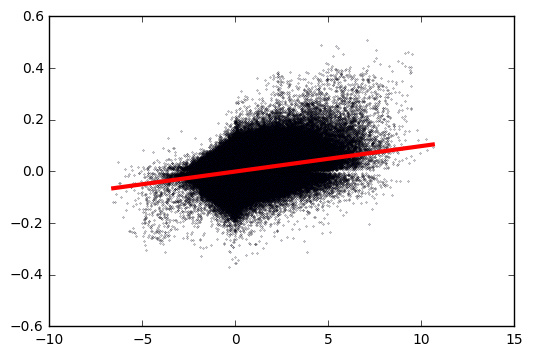

0.859139751228 0.0


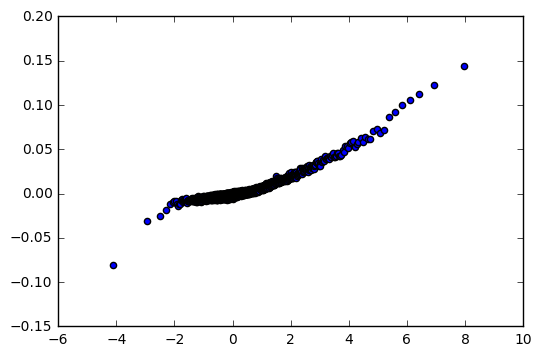

In [18]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
s, d = [], []
pairs = []
missing = 0
for experiment, scores in ism.items():
    for chrom, positions in scores.items():
        for pos, score in positions.items():
            try:
                s += [sharpr[experiment]['chr'+chrom][int(pos)]]
                d += [score]
                pairs += [(s[-1], d[-1])]
            except KeyError:
                missing += 1
                
print missing, len(pairs)
rho, pval = spearmanr(s, d)
print rho, pval
plt.scatter(s, d, s=.05)
plt.plot(np.unique(s), np.poly1d(np.polyfit(s, d, 1))(np.unique(s)), c='r', linewidth=3)
plt.show()
quantile_plot(pairs, 5000)

# Conservation Analysis

Using SiPhi scores obtained from: https://www.broadinstitute.org/mammals-models/29-mammals-project-supplementary-info

My understanding is that for each 12mer in the genome, they assessed the extent of conservation accross 29 mamalian genomes. They then reported 12mers at a FDR of 10%.

See the below plot for the quantile analysis.

I tried simply making a scatter plot and boxplot of the data, but it was a mess.

In [26]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with open('../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in si_phi: si_phi[chrom] = {}
        #if (start not in sharpr[sharpr.keys()[0]][chrom]
        #    and end not in sharpr[sharpr.keys()[0]][chrom]): continue
        for pos in range(start, end):
            #if (chrom in sharpr[sharpr.keys()[0]]
            #    and pos in sharpr[sharpr.keys()[0]][chrom]):
            si_phi[chrom][pos] = 1

IOError: [Errno 2] No such file or directory: '../data/conservation/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt'

In [10]:
mrpa_conserve = {}
for experiment, scores in sharpr.items():
    mrpa_conserve[experiment] = []
    for chrom, positions in scores.items():
        for pos, score in positions.items():
            mrpa_conserve[experiment].append((score, si_phi[chrom][pos] if pos in si_phi[chrom] else 0))

In [11]:
deep_conserve = {}
for experiment, scores in ism.items():
    deep_conserve[experiment] = []
    for chrom, positions in scores.items():
        for pos, score in positions.items():
            #if pos not in sharpr[experiment]['chr'+chrom]: continue
            if len(score) < 5: continue
            score = sum(score) / float(len(score))
            deep_conserve[experiment].append((score, si_phi['chr'+chrom][pos] if pos in si_phi['chr'+chrom] else 0))

('minP', 'K562')
0.729944234102 5.22078674626e-313


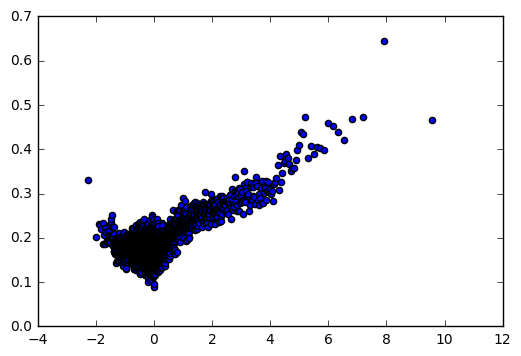

('SV40P', 'K562')
0.506492816147 7.83400169605e-161


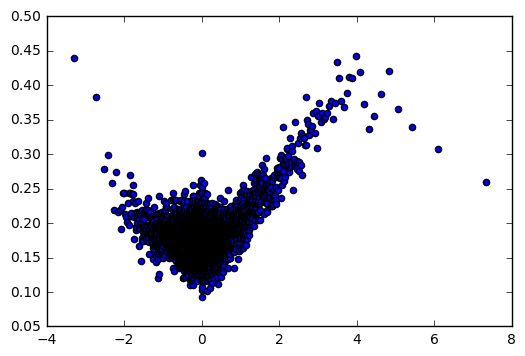

('combinedP', 'HepG2')
0.75014970048 0.0


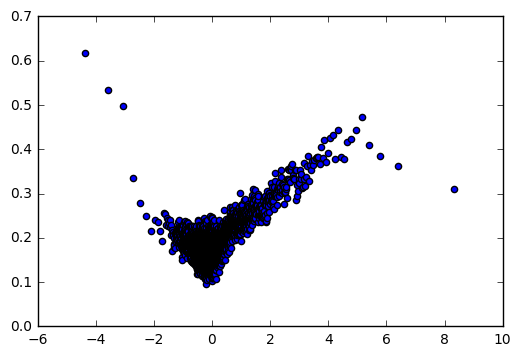

('minP', 'HepG2')
0.710397081845 0.0


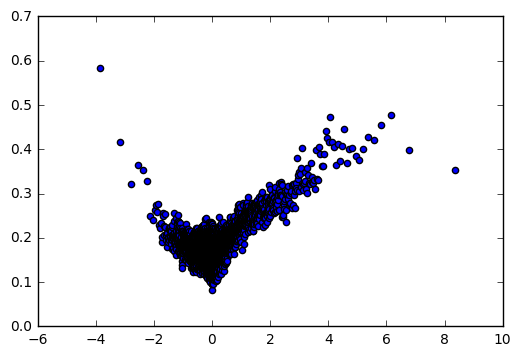

('SV40P', 'HepG2')
0.712956927294 0.0


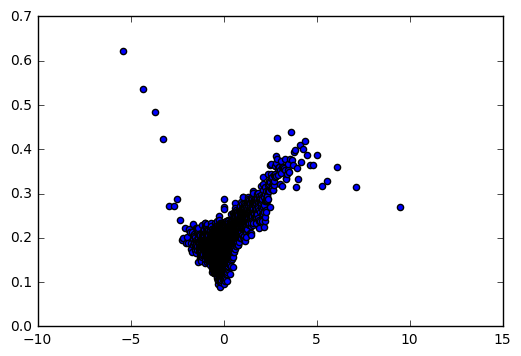

('combinedP', 'K562')
0.716446557499 0.0


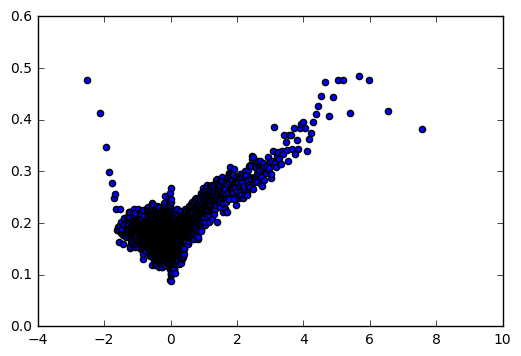

In [12]:
for experiment, scores in mrpa_conserve.items():
    print experiment
    quantile_plot(scores)

('minP', 'HepG2')
0.573103577273 9.08529770434e-212


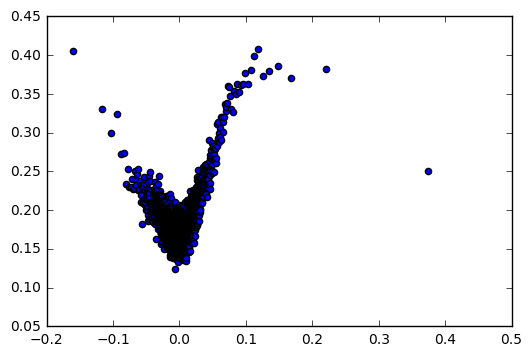

('minP', 'K562')
0.58084585528 1.12922492105e-216


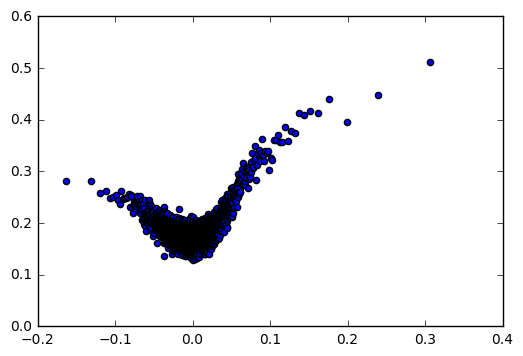

('SV40P', 'HepG2')
0.577646205751 4.3403949959e-215


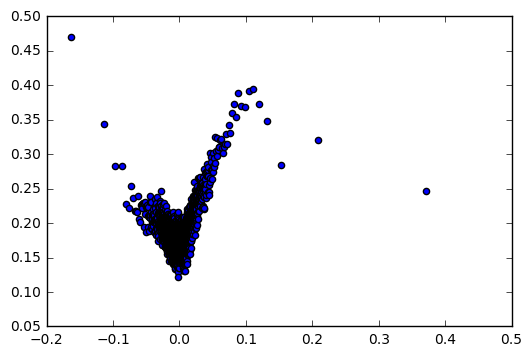

('SV40P', 'K562')
0.531879928522 1.29090712441e-181


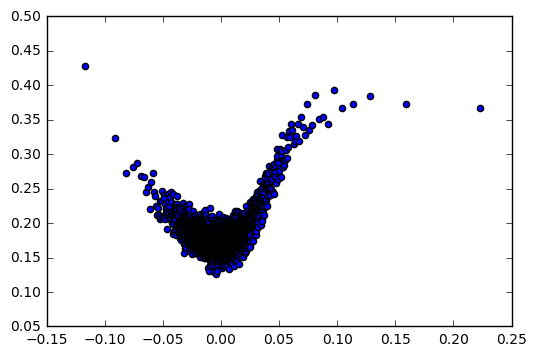

In [24]:
for experiment, scores in deep_conserve.items():
    print experiment
    quantile_plot(scores, 5000)

# Motif Overlaps

In [27]:
hepG2_centipede = {}
with open('../data/centipede/HEPG2_liftover.bed') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end, motif = line.strip().split()[:4]
        start, end = int(start), int(end)
        if chrom not in hepG2_centipede:hepG2_centipede[chrom] = {}
        for pos in range(start, end):
            hepG2_centipede[chrom][pos] = motif

k562_centipede = {}
with open('../data/centipede/K562_liftover.bed') as regions:
    regions.readline()
    for line in regions:
        chrom, start, end, motif = line.strip().split()[:4]
        start, end = int(start), int(end)
        if chrom not in k562_centipede: k562_centipede[chrom] = {}
        for pos in range(start, end):
            k562_centipede[chrom][pos] = motif    

In [15]:
mrpa_centipede = {}
motif_scores = {}
for experiment, scores in sharpr.items():
    mrpa_centipede[experiment] = []
    motif_scores[experiment] = {}
    for chrom, positions in scores.items():
        for pos, score in positions.items():
            if experiment[0] == 'HepG2':
                is_motif = 1 if pos in hepG2_centipede[chrom] else 0
                if pos in hepG2_centipede[chrom]:
                    motif = hepG2_centipede[chrom][pos]
                    if not motif in motif_scores[experiment]:
                        motif_scores[experiment][motif] = []
                    motif_scores[experiment][motif] += [score]
            else:
                is_motif = 1 if pos in k562_centipede[chrom] else 0
                if pos in k562_centipede[chrom]:
                    motif = k562_centipede[chrom][pos]
                    if not motif in motif_scores[experiment]:
                        motif_scores[experiment][motif] = []
                    motif_scores[experiment][motif] += [score]
            mrpa_centipede[experiment].append((score, is_motif))


In [29]:
deep_centipede = {}
deep_motif_scores = {}
for experiment, scores in ism.items():
    deep_centipede[experiment] = []
    deep_motif_scores[experiment] = {}
    for chrom, positions in scores.items():
        chrom = 'chr' + chrom
        for pos, score in positions.items():
            if pos not in sharpr[experiment][chrom]: continue
            #score = sum(score) /float(len(score))
            if experiment[0] == 'HepG2':
                is_motif = 1 if pos in hepG2_centipede[chrom] else 0
                if pos in hepG2_centipede[chrom]:
                    motif = hepG2_centipede[chrom][pos]
                    if not motif in deep_motif_scores[experiment]:
                        deep_motif_scores[experiment][motif] = []
                    deep_motif_scores[experiment][motif] += [score]
            else:
                is_motif = 1 if pos in k562_centipede[chrom] else 0
                if pos in k562_centipede[chrom]:
                    motif = k562_centipede[chrom][pos]
                    if not motif in deep_motif_scores[experiment]:
                        deep_motif_scores[experiment][motif] = []
                    deep_motif_scores[experiment][motif] += [score]
            deep_centipede[experiment].append((score, is_motif))

('minP', 'K562')
0.900588884428 0.0


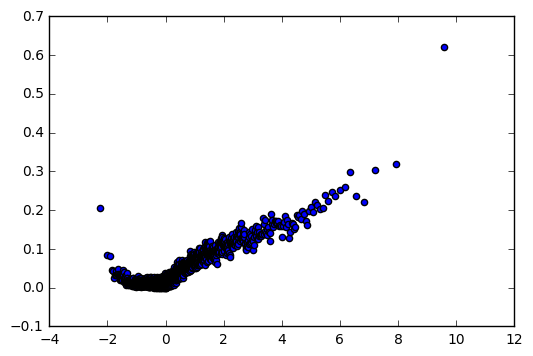

('SV40P', 'K562')
0.799234527331 0.0


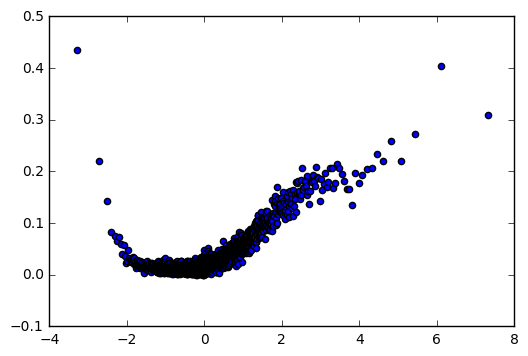

('combinedP', 'HepG2')
0.882742398558 0.0


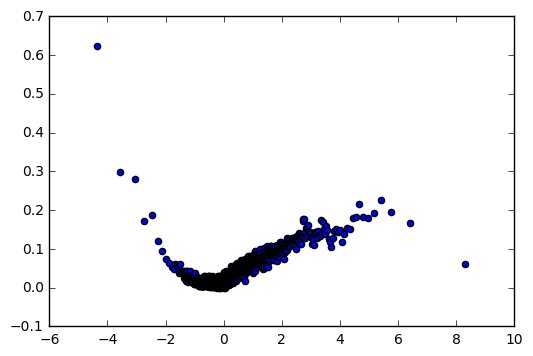

('minP', 'HepG2')
0.837787447018 0.0


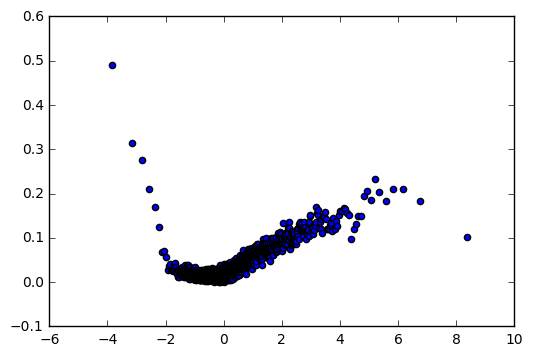

('SV40P', 'HepG2')
0.856540518397 0.0


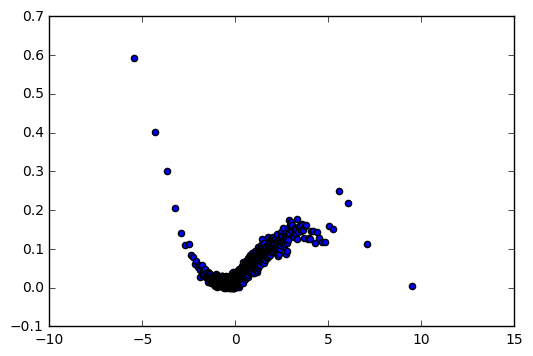

('combinedP', 'K562')
0.897375722892 0.0


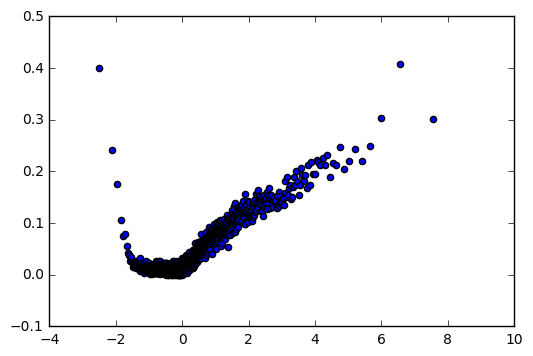

In [17]:
for experiment, scores in mrpa_centipede.items():
    print experiment
    quantile_plot(scores)

('minP', 'HepG2')
-0.0304893689326 0.830104801537


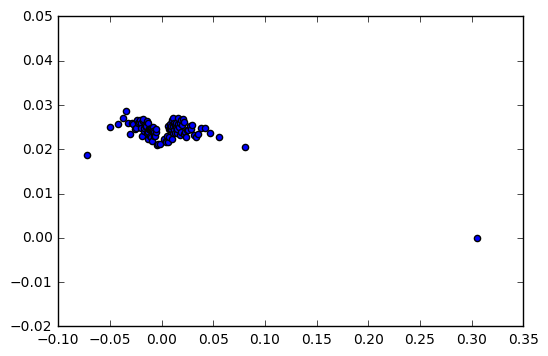

('minP', 'K562')
0.417900254901 0.00184790592684


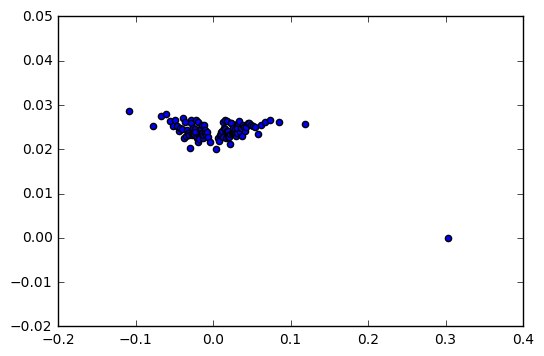

('SV40P', 'HepG2')
0.0906835710507 0.518423996617


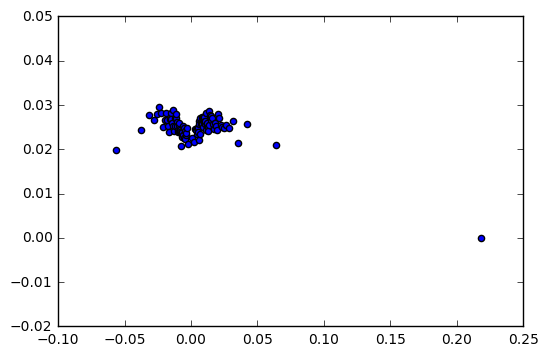

('SV40P', 'K562')
0.445571571389 0.00105055414033


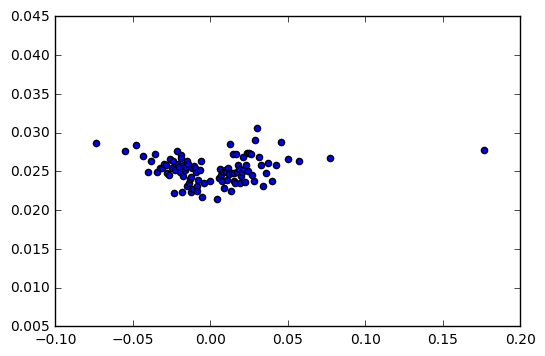

In [37]:
for experiment, scores in deep_centipede.items():
    print experiment
    quantile_plot(scores, 100)

[('minP', 'K562'), ('SV40P', 'K562'), ('combinedP', 'HepG2'), ('minP', 'HepG2'), ('SV40P', 'HepG2'), ('combinedP', 'K562')]
238


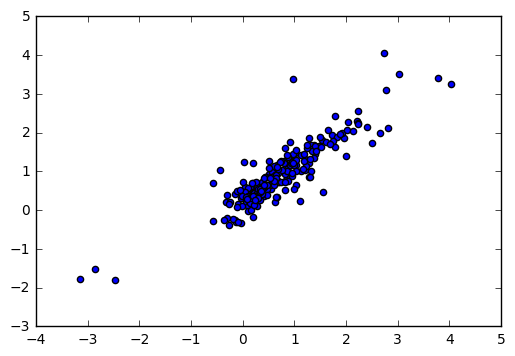

In [19]:
print motif_scores.keys()
hepG2, k562 = [], []
exp1, exp2 = ('combinedP', 'HepG2'), ('combinedP', 'K562')
print len(motif_scores[exp1].keys())
for motif, h in motif_scores[exp1].items():
    if not motif in motif_scores[exp2]: continue
    k = motif_scores[exp2][motif]
    
    hepG2 += [sum(h) / float(len(h))]
    k562 += [sum(k) / float(len(k))]
plt.scatter(hepG2, k562)
plt.show()

[('minP', 'HepG2'), ('minP', 'K562'), ('SV40P', 'HepG2'), ('SV40P', 'K562')]
238


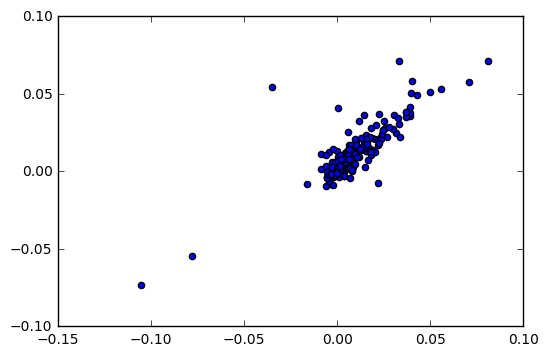

In [20]:
print deep_motif_scores.keys()
hepG2, k562 = [], []
exp1, exp2 = ('SV40P', 'HepG2'), ('SV40P', 'K562')
print len(deep_motif_scores[exp1].keys())
for motif, h in deep_motif_scores[exp1].items():
    if not motif in deep_motif_scores[exp2]: continue
    k = deep_motif_scores[exp2][motif]
    
    hepG2 += [sum(h) / float(len(h))]
    k562 += [sum(k) / float(len(k))]
plt.scatter(hepG2, k562)
plt.show()

In [21]:
encode = {}
with open('../data/encode/matches.txt') as regions:
    for i, line in enumerate(regions):
        motif, chrom, start, end, strand = line.strip().split()
        start, end = int(start), int(end)
        if chrom not in encode: encode[chrom] = {}
        if start not in sharpr.values()[0][chrom]: continue
        for pos in range(start, end):
            if pos not in encode[chrom]: encode[chrom][pos] = set()
            encode[chrom][pos].add(motif)

IOError: [Errno 2] No such file or directory: '../data/encode/matches.txt'

In [ ]:
mrpa_encode = {}
encode_scores = {}
for experiment, scores in sharpr.items():
    mrpa_encode[experiment] = []
    encode_scores[experiment] = {}
    for chrom, positions in scores.items():
        for pos, score in positions.items():
            mrpa_encode[experiment] += [(score, 1 if pos in encode[chrom] else 0)]
            if pos in encode[chrom]:
                for motif in encode[chrom][pos]:
                    if not motif in encode_scores[experiment]:
                        encode_scores[experiment][motif] = []
                    encode_scores[experiment][motif] += [score]

In [ ]:
for experiment, scores in mrpa_encode.items():
    print experiment
    quantile_plot(scores)

In [ ]:
hepG2, k562 = [], []
exp1, exp2 = ('combinedP', 'HepG2'), ('combinedP', 'K562')

for motif, h in encode_scores[exp1].items():
    if not motif in encode_scores[exp2]: continue
    k = encode_scores[exp2][motif]
    
    hepG2 += [sum(h) / float(len(h))]
    k562 += [sum(k) / float(len(k))]
plt.scatter(hepG2, k562)
plt.show()